# ASTR 596: FDS Homework 5: Hunting for Exoplanets (Due April 1 at Noon)


### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg" width="500">


### But is there a system like our own Solar system with 8 planets (sorry Pluto)? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `python -m pip install lightkurve --upgrade`

### I've included some code to get the light curve, clean it and remove the NaNs, and some outliers (you can judge the wisdom of strong outlier removal when you are hunting for planets), and bin the light curve a little bit in time.


<hr>

#### Hints:


* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html), in particular [this one](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html)

* once you get to a periodogram with `lightkurve`, `find_peaks` in `scipy` can help identify the exoplanet peaks

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
%matplotlib notebook
%pylab
import numpy as np
import astropy.table as at
import astropy.units as u
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.signal import find_peaks, find_peaks_cwt

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
### RUN THIS
lcfs = lk.search_lightcurve('Kepler-90', mission='Kepler').download_all()

In [3]:
### RUN THIS
def squelch_rednoise(lc):
    corrected_lc = lc.remove_outliers(sigma_upper=10, sigma_lower=10).normalize().flatten(window_length=901)
    return corrected_lc

<IPython.core.display.Javascript object>


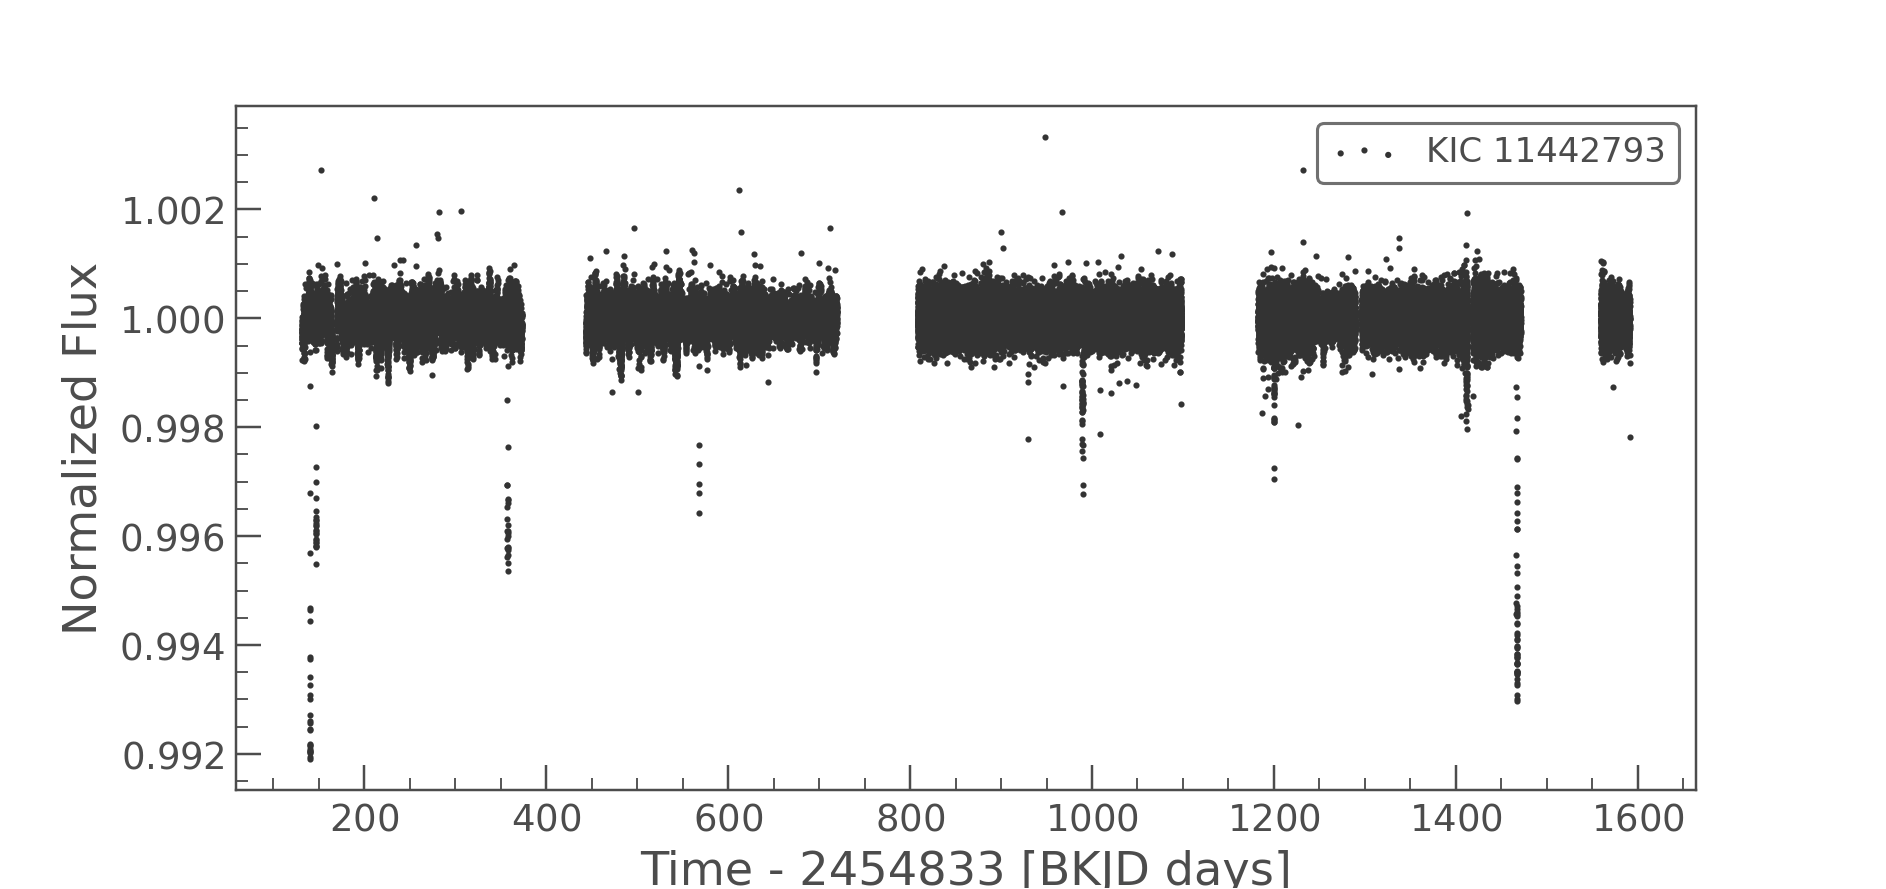

In [4]:
### RUN THIS
stitched_lc = lcfs.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans().bin(time_bin_size=15*u.min)
clc.scatter();

# This is the data we'll deal with

# Q1. First, calculate the periodogram using lightkurve. Use the `bls` method. Look for planets between 50 and 500 day periods with a grid spacing of 0.01d - this is coarse. Use `scipy.signal.find_peaks` to identify peaks in the periodogram. Remember to exclude any peaks arising from the Earth's revolution. Plot the periodogram and highlight the peak locations. (25 pts)


<IPython.core.display.Javascript object>


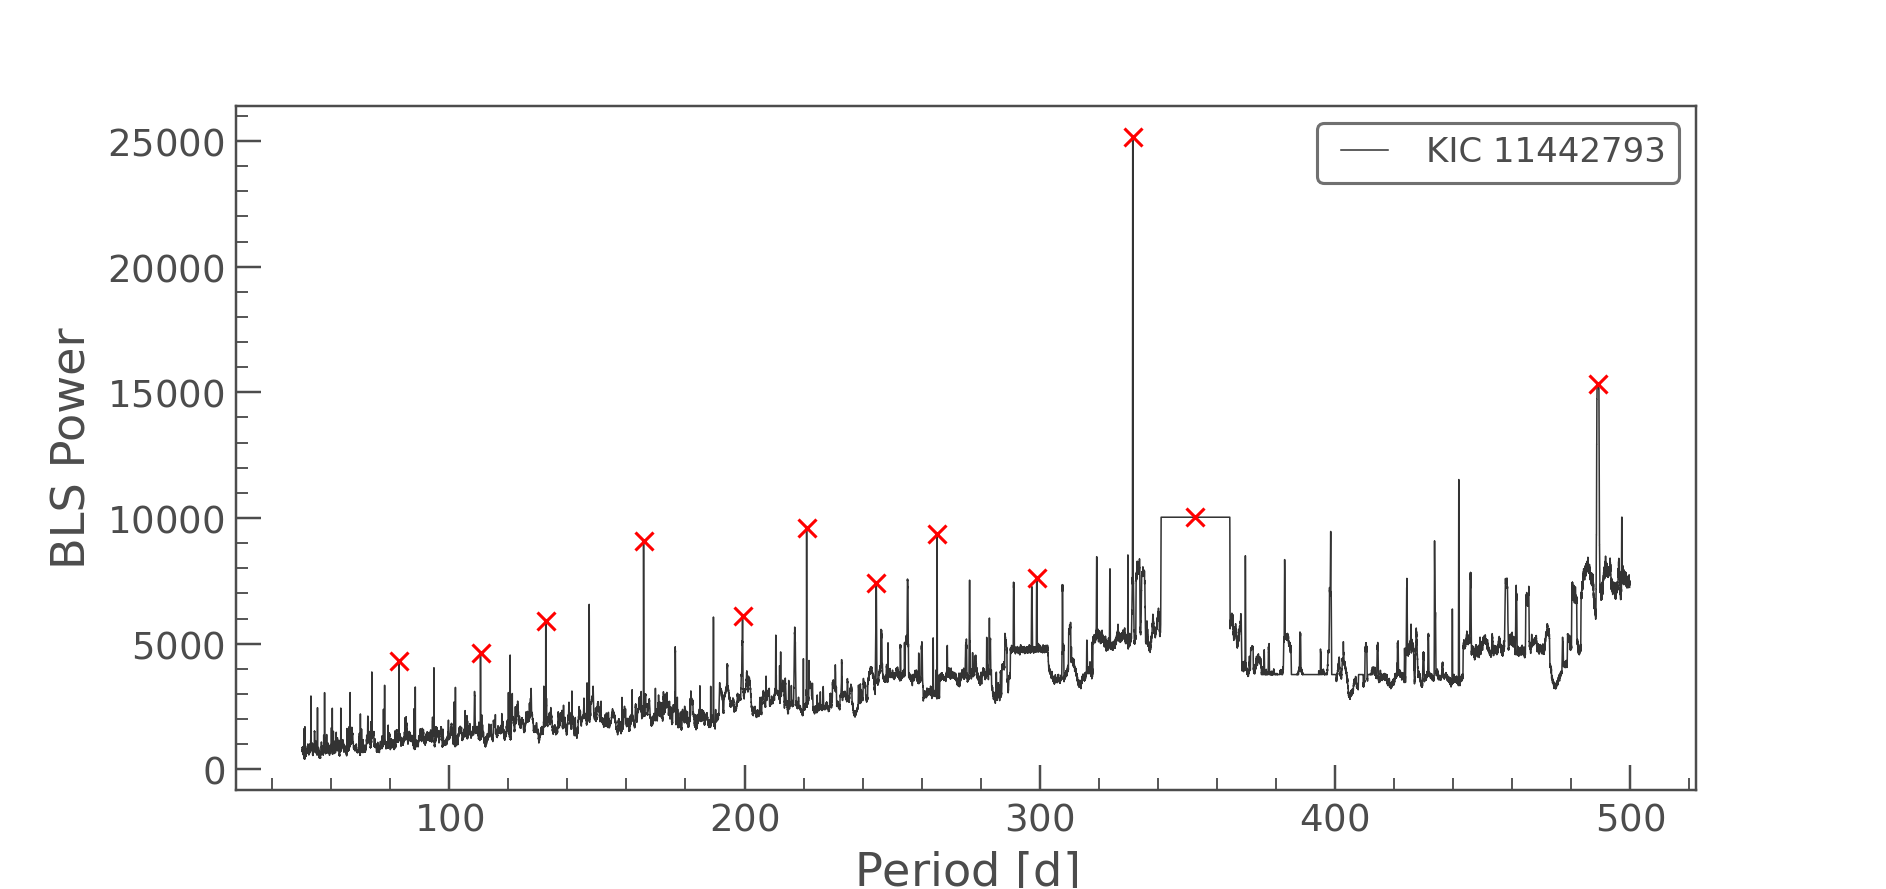

In [5]:
periodogram = clc.to_periodogram(method="bls", period=np.arange(50, 500, .01))
peaks, _ = find_peaks(periodogram.power, height=4000, distance=2000)
periodogram.plot()
# exclude detected peak near 365 days - we should probably do this by filtering on period value but meh.
peaks = peaks[(periodogram.period[peaks].value -365 < -10)  |  (periodogram.period[peaks].value - 365 > 120)]
ax = plt.gca()
ax.plot(1./periodogram.frequency[peaks], periodogram.power[peaks], marker='x', color='r', linestyle='None');

# Q2. a. The periodogram function from lightkurve can also get a transit time and peak power using `periodogram.transit_time` and `periodogram.power` - you'll want both. Get a sorted list of candidate periods, sorted by peak power... (10 pts)

In [6]:
candidate_periods = 1./periodogram.frequency[peaks]
candidate_power = periodogram.power[peaks]
candidate_transit_times = periodogram.transit_time[peaks]
period_info = at.Table((candidate_periods, candidate_power), names=['period','power']) 
period_info.sort(keys='power')
period_info[::-1]

period,power
d,
float64,float64
331.569999999944,25161.11009545872
489.24999999991263,15323.441695670634
352.84999999993977,10032.968351806629
221.03999999996594,9585.001252784747
265.2599999999572,9381.398045495385
165.77999999997695,9104.587577067876
299.01999999995047,7609.510045471913
244.66999999996125,7410.235816240554


# Q2. b. Next sort the list of periods from longest to shorted. Check if each period has a period in your list that is either 1/2 or 1/3 the same value. If it is, exclude it. If not keep it. Select the four periods with the highest power between 0 to 100d, 100d and 200d, 200d and 300d and 300d and 400d. (15 pts)

In [7]:
test_periods = []
test_tt = []
period_info.sort(keys='period')
for i, period in enumerate(period_info['period'][::-1]):
    if period in test_periods:
        pass
    test_period_2 = period/2.
    test_period_3 = period/3.
    print(period, test_period_2, test_period_3)
    
    delta_period_2 = np.abs(period_info['period'] - test_period_2)
    delta_period_3 = np.abs(period_info['period'] - test_period_3)
    
    if np.any(delta_period_2.value < 0.5) or np.any(delta_period_3.value < 0.5):
        print(f'Excluding period {period}')
        continue
    else:
        test_periods.append(period)
        test_tt.append(candidate_transit_times[i])
test_periods = np.array(test_periods)
test_tt = np.array(test_tt)

out_periods = []
out_tt = []
for i in (0, 1, 2, 3):
    tmin = 100*i
    tmax = 100*(i+1)
    ind = (test_periods >= tmin) & (test_periods < tmax)
    out_periods.append(test_periods[ind][0])
    out_tt.append(test_tt[ind][0])
out_periods 

489.24999999991263 244.62499999995632 163.0833333333042
Excluding period 489.24999999991263
352.84999999993977 176.42499999996988 117.6166666666466
331.569999999944 165.784999999972 110.52333333331467
Excluding period 331.569999999944
299.01999999995047 149.50999999997524 99.67333333331682
265.2599999999572 132.6299999999786 88.41999999998573
Excluding period 265.2599999999572
244.66999999996125 122.33499999998062 81.55666666665375
221.03999999996594 110.51999999998297 73.67999999998865
Excluding period 221.03999999996594
199.32999999997028 99.66499999998514 66.44333333332342
165.77999999997695 82.88999999998848 55.25999999999232
Excluding period 165.77999999997695
132.62999999998357 66.31499999999178 44.20999999999452
110.51999999998796 55.25999999999398 36.83999999999599
82.88999999999345 41.444999999996725 27.629999999997818


[82.88999999999345, 199.32999999997028, 299.01999999995047, 352.84999999993977]

# Q3. Select each peak period from the coarse grid in Q2.b. and then use lightkurve algorithm to refine the period within +/- 5 days, and get the best period. (25 pts)

In [8]:
best_periods = []
best_t0 = []
best_dur = []
for i, period in enumerate(out_periods): 
    bls = clc.to_periodogram(method="bls", period=np.arange(period-5, period+5, .001))
    best_periods.append(bls.period_at_max_power)
    best_t0.append(bls.transit_time_at_max_power)
    best_dur.append(bls.duration_at_max_power)

# Q4. Use lightkurve.fold to plot the folded light curve for each of the best periods in Q3. (25 pts)

<IPython.core.display.Javascript object>


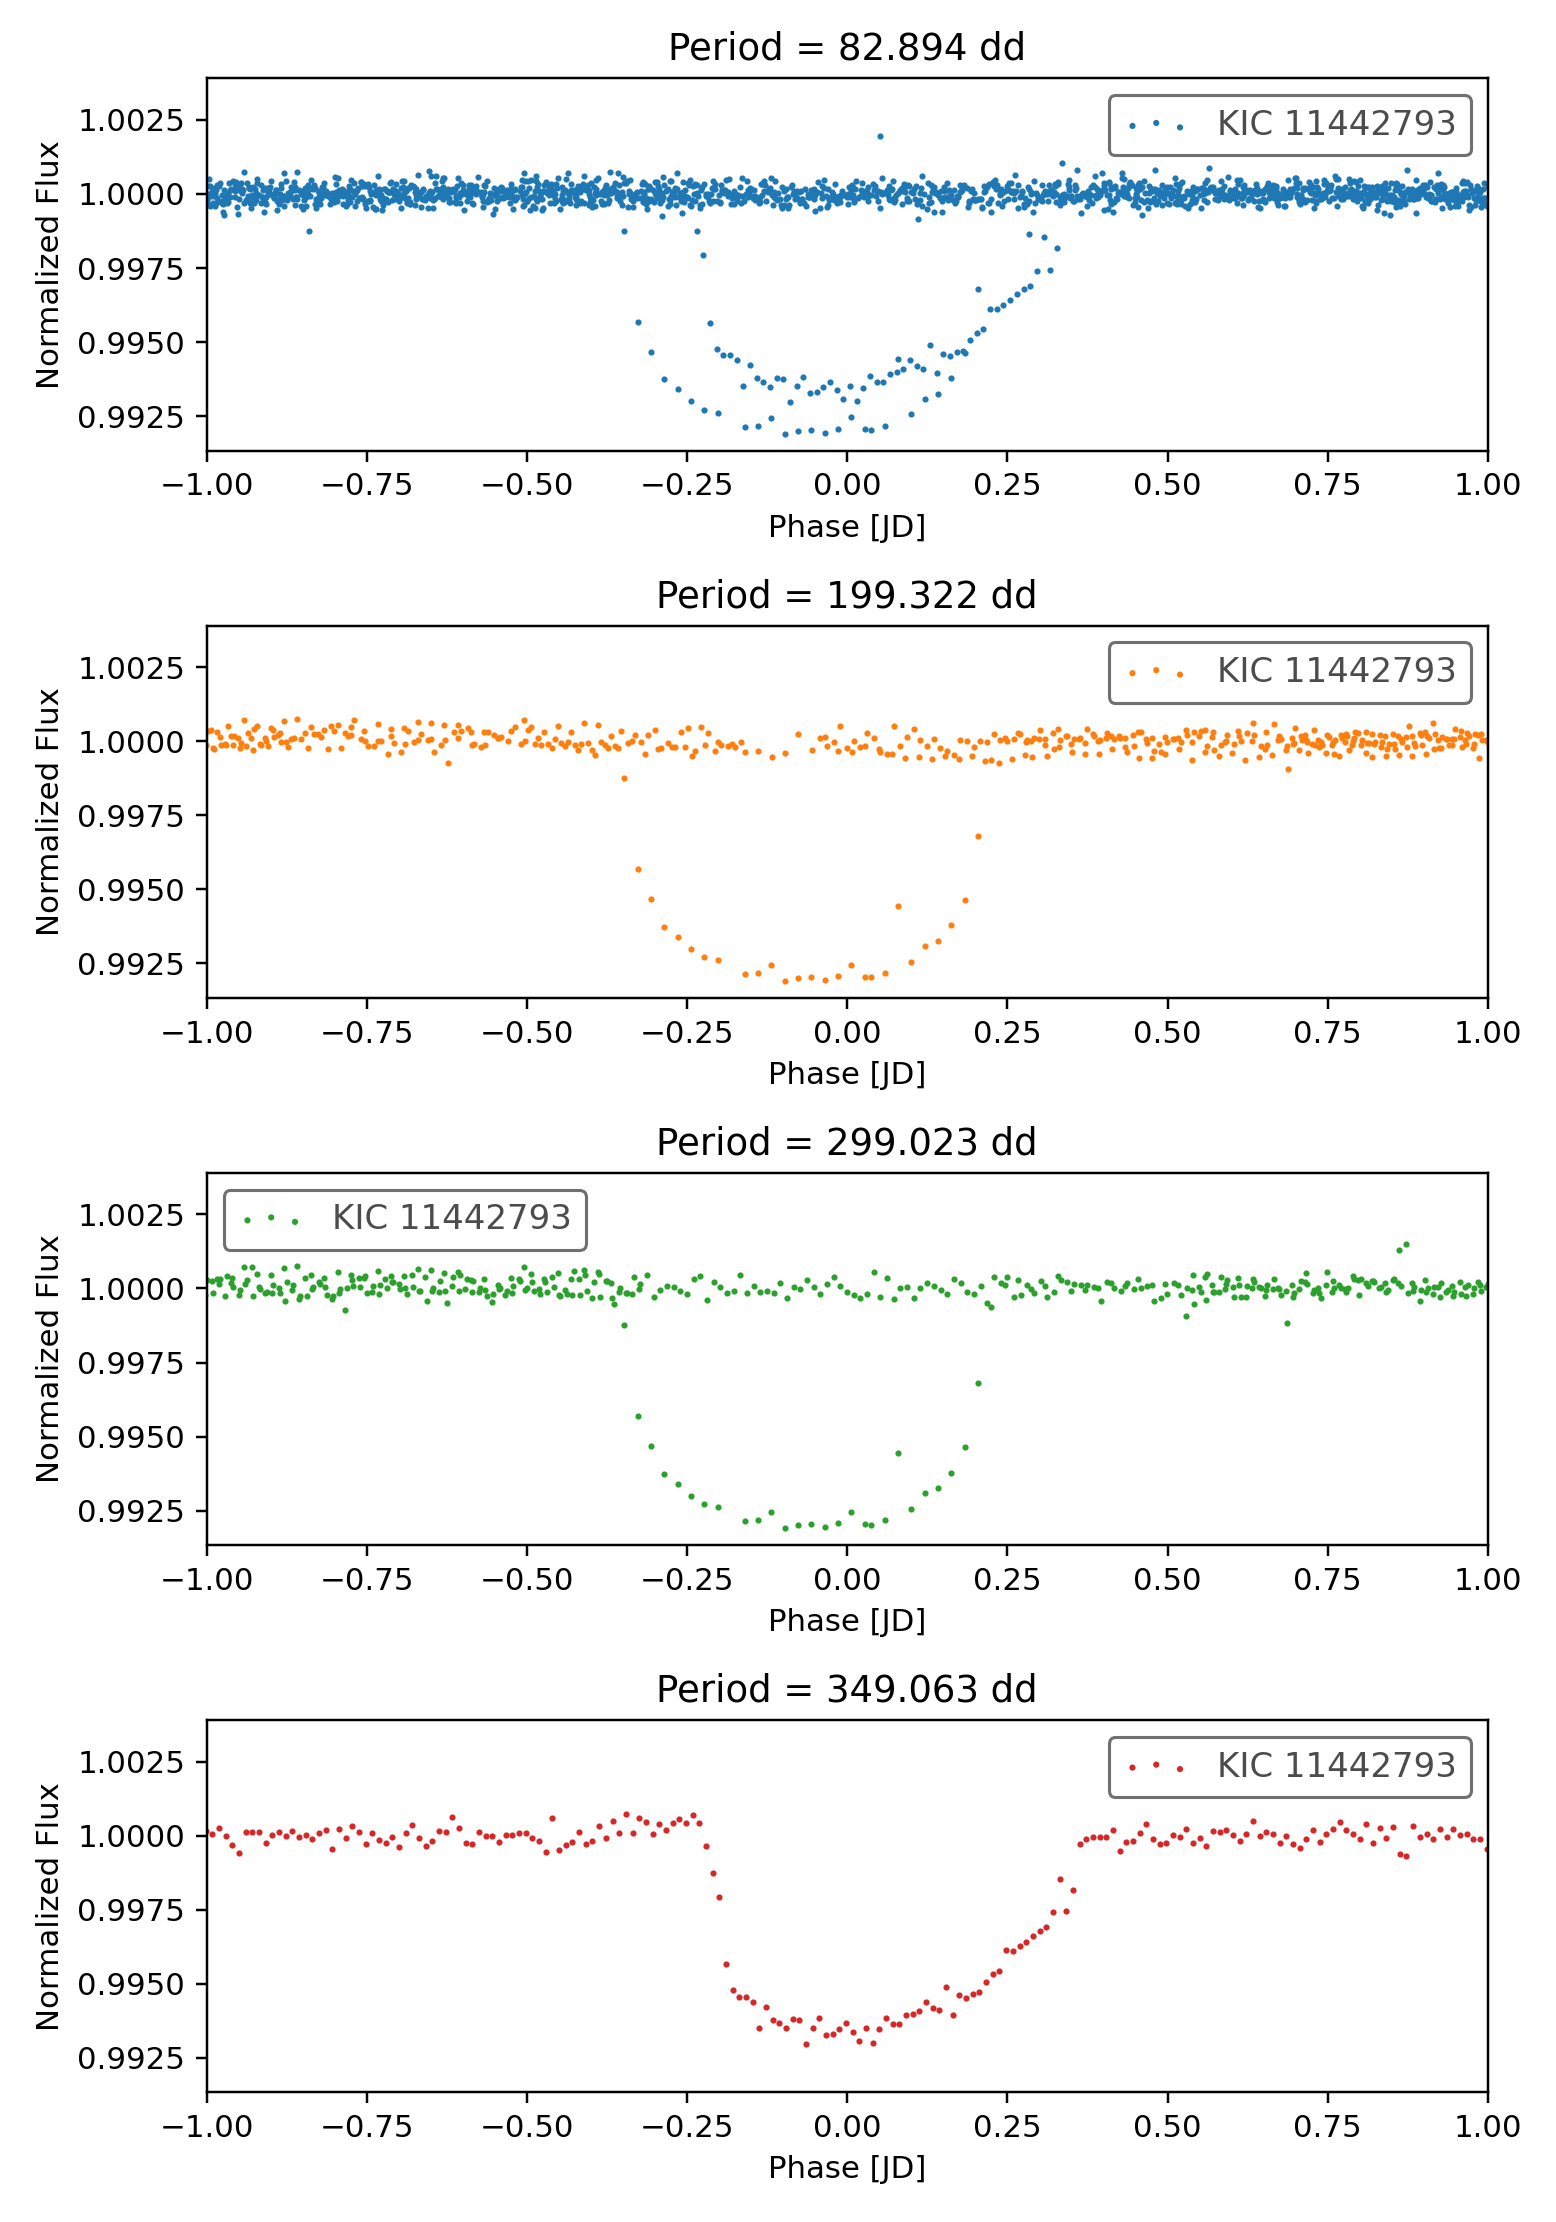

In [9]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7, 10))
for i, best_period in enumerate(best_periods):
    ax = axs[i]
    t0 = best_t0[i]
    clc.fold(period=best_period, epoch_time=t0).scatter(ax=ax, marker='.', color=f'C{i}')
    ax.set_title(f'Period = {best_period:.3f}d')
    ax.set_xlim(-1, 1)
fig.tight_layout()